In [11]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv("processed_loans_2007.csv")
df.shape

(37675, 39)

In [13]:
df.loan_status.value_counts(normalize=True)


1    0.856961
0    0.143039
Name: loan_status, dtype: float64

It seems that we don't have much that are unapproved. Therefore, it's not a good idea to just train it with the normal accuracy benchmarks. That would be superficially high and would not be helpful in our predictions. This is a good example to use high recall(true positive) and low fallout (false positive) rates for evaluation.

True positive rate = (True postives)/(True positives + false negatives)

False positive rate = (false positives)/(false positive + true negatives)

# Machine Learning Algorithm 1: Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
lr = LogisticRegression()

features = df.columns.tolist()
features.remove("loan_status")
target = "loan_status"

#k-fold CV This is crucial to prevent overfitting due to the little data that we have for loan_status == 0.
pred = cross_val_predict(lr,df[features],df[target],cv=3)
pred = pd.Series(pred)

#doing metrics with high recall and low fallout calculations
temp = (pred == 0) &(df.loan_status == 0)
tn = len(pred[temp]) #the number of true negatives in a prediction
temp = (pred == 1) &(df.loan_status == 1)
tp = len(pred[temp])
temp = (pred == 0) &(df.loan_status == 1)
fn = len(pred[temp])
temp = (pred == 1) &(df.loan_status == 0)
fp = len(pred[temp])

#false positive rate and true positive rate
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
print(fpr,tpr)
print(fpr,tpr, "\nRatio = ",tpr/fpr)
#very high fpr and tpr. That means that we just predict everything with 1 due to class imbalances

0.9873817034700315 0.9963761382642632
0.9873817034700315 0.9963761382642632 
Ratio =  1.009109379647832


It seems that even with the classification of false positive rate and true positive rate alone is not helping with our model. It is then crucial to somehow solve the binary ratio of our target with data manipulation. We can:
1. Oversample and undersample
2. Penalize for each false classication of the minority of our output

In [15]:
lr = LogisticRegression(class_weight="balanced") #this will set the data proportion inversely related to the penalty

#k-fold CV This is crucial to prevent overfitting due to the little data that we have for loan_status == 0.
pred = cross_val_predict(lr,df[features],df[target],cv=3)
pred = pd.Series(pred)

#doing metrics with high recall and low fallout calculations
temp = (pred == 0) &(df.loan_status == 0)
tn = len(pred[temp]) #the number of true negatives in a prediction
temp = (pred == 1) &(df.loan_status == 1)
tp = len(pred[temp])
temp = (pred == 0) &(df.loan_status == 1)
fn = len(pred[temp])
temp = (pred == 1) &(df.loan_status == 0)
fp = len(pred[temp])

#false positive rate and true positive rate
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
print(fpr,tpr)
print(fpr,tpr, "\nRatio = ",tpr/fpr)

0.44702171089255893 0.6830205042433253
0.44702171089255893 0.6830205042433253 
Ratio =  1.5279358644114902


We'll have a false positive rate of 43% (money lost) with 66% of true positive rate (correct out of the total loans given). This is not good. It means that we would lose typically 2/3 of the tries for a minimal gain of interest rate. We don't know how much principle we can recoup with specified interest rate. As an investor, one needs to protect his/her principle amount. Let's apply a harsher penalty to see if it's going to improve.

It makes sense that when we're stricter in the loan give out, it helps us protect our principle and has a better gain. In term of statistic, it's better for risk management but we'll end up losing a lot of customers that way due to a low revenue. Obviously, the more penalty we give - the better we ratio we can get...but it's not always the best case since costs such as operational expenses are consistent and can eat up a larger proportion of our profits.

In [48]:
import warnings
warnings.filterwarnings("ignore")
penalty_ratio = [i for i in range (1,30)] #POR = 6

def logistic_reg(penalty_ratio,df_features,df_target):
    result = []
    for i in penalty_ratio:
        lr = LogisticRegression(class_weight={1:1, 0:i})
        pred = cross_val_predict(lr,df_features,df_target,cv=3)
        pred = pd.Series(pred)

        temp = (pred == 0) &(df.loan_status == 0)
        tn = len(pred[temp])
        temp = (pred == 1) &(df.loan_status == 1)
        tp = len(pred[temp])
        temp = (pred == 0) &(df.loan_status == 1)
        fn = len(pred[temp])
        temp = (pred == 1) &(df.loan_status == 0)
        fp = len(pred[temp])

        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        ratio = tpr/fpr
        result.append((tpr,fpr,ratio))
    return result

metrics = logistic_reg(penalty_ratio,df[features],df[target])
tpr = [i[0] for i in metrics]
ratio = [i[2] for i in metrics]

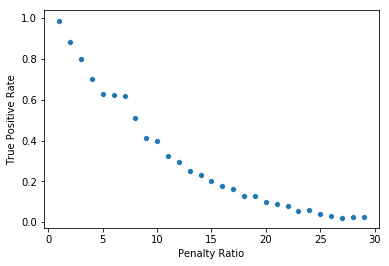

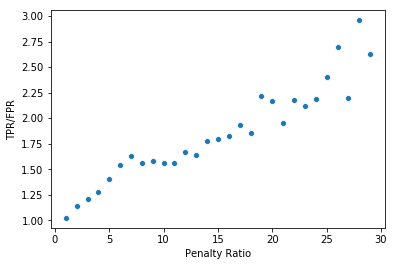

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.scatterplot(penalty_ratio,tpr)
plt.xlabel("Penalty Ratio")
plt.ylabel("True Positive Rate")
plt.show()

sns.scatterplot(penalty_ratio,ratio)
plt.xlabel("Penalty Ratio")
plt.ylabel("TPR/FPR")
plt.show()

In general, increasing penalty helps with the ratio and avoid bad loans. However, one needs to evaluate the required true positive rate required to cover operational cost. Let's look at other algorithm.

# Machine Learning Model #2: Random Forest Algorithm

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

#using random forest to see if it improves a lot over the older logistic regression
rf = RandomForestClassifier(random_state=1,class_weight={1:1, 0:30})
pred = cross_val_predict(rf,df[features],df[target],cv=3)
pred = pd.Series(pred)

#doing metrics with high recall and low fallout calculations
temp = (pred == 0) &(df.loan_status == 0)
tn = len(pred[temp]) #the number of true negatives in a prediction
temp = (pred == 1) &(df.loan_status == 1)
tp = len(pred[temp])
temp = (pred == 0) &(df.loan_status == 1)
fn = len(pred[temp])
temp = (pred == 1) &(df.loan_status == 0)
fp = len(pred[temp])

#false positive rate and true positive rate
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
print(fpr,tpr, "\nRatio = ",tpr/fpr)

0.6459454444238263 0.6629189122220157 
Ratio =  1.0262769370768292


The ratio is still very bad, but it seems that the False positive Rate is higher than the simple Logistic Regression Model. Let's see what will happen if we plot them out.

In [51]:
penalty_ratio = [i for i in range (1,30)] #POR = 6
def rf_class(penalty_ratio,df_features,df_target):
    result = []
    for i in penalty_ratio:
        rf = RandomForestClassifier(class_weight={1:1, 0:i})
        pred = cross_val_predict(rf,df_features,df_target,cv=3)
        pred = pd.Series(pred)

        temp = (pred == 0) &(df.loan_status == 0)
        tn = len(pred[temp])
        temp = (pred == 1) &(df.loan_status == 1)
        tp = len(pred[temp])
        temp = (pred == 0) &(df.loan_status == 1)
        fn = len(pred[temp])
        temp = (pred == 1) &(df.loan_status == 0)
        fp = len(pred[temp])

        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        ratio = tpr/fpr
        result.append((tpr,fpr,ratio))
    return result

metrics2 = rf_class(penalty_ratio,df[features],df[target])
tpr2 = [i[0] for i in metrics2]
ratio2 = [i[2] for i in metrics2]

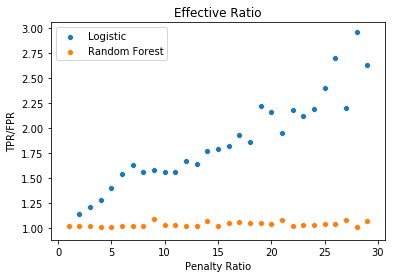

In [52]:
sns.scatterplot(penalty_ratio,ratio)
sns.scatterplot(penalty_ratio,ratio2)
plt.xlabel("Penalty Ratio")
plt.ylabel("TPR/FPR")
plt.legend(["Logistic","Random Forest"])
plt.title("Effective Ratio")
plt.show()

Et Voila, it looks like more complication doesn't neccessarily become better. The simple logistic function yielded better result based on our benchmark. We will need to engineer the features again and tune our algorithms for better classification